In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score,roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler


### Cargue Data

In [33]:
df = pd.read_csv("D:\\visualization\\formula1\\data\\processed\\df_train_v2.csv")

In [34]:
# Seleccionamos solo las columnas numéricas
numeric_columns = ['driver_points', 'completed_laps', 'fastest_lap', 'fastest_lap_speed', 
                   'qualifying_position', 'driver_standing_points', 
                   'driver_wins', 'constructor_points', 'constructor_wins']

# Creamos el escalador
scaler = MinMaxScaler()

# Aplicamos la normalización
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


In [35]:
df.head()

,driverId,year,final_position,driver_points,completed_laps,fastest_lap,fastest_lap_speed,qualifying_position,driver_standing_points,driver_wins,constructor_points,constructor_wins
0,2,2009,10,0.00,0.666667,0.554217,0.755185,0.434783,0.000000,0.0,0.000000,0.0
1,3,2009,6,0.06,0.666667,0.554217,0.763667,0.173913,0.005217,0.0,0.003488,0.0
2,4,2009,5,0.08,0.666667,0.614458,0.748951,0.478261,0.006957,0.0,0.004651,0.0
3,7,2009,8,0.02,0.666667,0.578313,0.733085,0.826087,0.001739,0.0,0.003488,0.0
4,8,2009,15,0.00,0.632184,0.397590,0.752199,0.347826,0.000000,0.0,0.000000,0.0


In [36]:
df.shape

(7736, 12)

In [37]:
df['final_position'] = np.where(df['final_position'] == 1,1,0)

df['final_position'].value_counts()

final_position
0    7349
1     387
Name: count, dtype: int64

### Creación train, val y test

In [38]:

# Primero dividimos en train + validation y test (estratificando por 'year')
train_val, test = train_test_split(df, test_size=0.2,
                                   # stratify=df['year'],
                                    random_state=42)

# Luego dividimos train + validation en train y validation
train, validation = train_test_split(train_val, test_size=0.25,
                                      #stratify=train_val['year'],
                                        random_state=42) 
# El 0.25 en esta segunda división hace que validation sea el 20% del total

# Asignar etiquetas de conjunto de datos
train['dataset'] = 'train'
validation['dataset'] = 'validation'
test['dataset'] = 'test'

# Concatenar los conjuntos nuevamente en un solo DataFrame
df_labeled = pd.concat([train, validation, test])

In [39]:
df_labeled = df_labeled.drop_duplicates()

In [40]:
df_labeled.groupby(['dataset','year']).agg({'dataset':'count',
                                            'final_position':'sum'})

dataset  final_position
dataset    year                         
test       2004       68               3
           2005       82               8
           2006       79               4
           2007       61               2
           2008       74               5
           2009       70               1
           2010       90               6
           2011       84               2
           2012       91               6
           2013       69               6
           2014       70               4
           2015       67               4
           2016       88               5
           2017       71               5
           2018       78               3
           2019       77               4
           2020       75               4
           2021       88               4
           2022       71               2
           2023       95               5
train      2004      203               9
           2005      205               6
           2006      214               7
           2007      221              12
           2008      207               8
           2009      186              12
           2010      257              12
           2011      266              13
           2012      275              11
           2013      248               9
           2014      224               8
           2015      207              11
           2016      273              12
           2017      235              12
           2018      238              16
           2019      251              15
           2020      190               9
           2021      231              13
           2022      265              15
           2023      245              12
validation 2004       65               6
           2005       67               5
           2006       66               7
           2007       68               3
           2008       57               5
           2009       62               4
           2010       82               1
           2011       89               4
           2012       89               3
           2013       93               4
           2014       95               7
           2015       77               4
           2016       78               4
           2017       68               3
           2018       83               2
           2019       86               2
           2020       63               4
           2021       83               4
           2022       90               5
           2023       86               5

### Feature Selection

In [41]:
def calcular_feature_importance(df, target='final_position', n=5):
    # Eliminar las columnas 'driverId', 'year' y 'dataset'
    df = df.drop(columns=['driverId', 'year', 'dataset'])
    
    # Separar las características (X) y la variable objetivo (y)
    X = df.drop(columns=[target])
    y = df[target]
    
    # No es necesario codificar 'y' ya que es una variable binaria 0 o 1
    # Entrenar el modelo de Random Forest directamente sobre el DataFrame de train
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Obtener la importancia de características
    feature_importances = rf.feature_importances_
    
    # Crear un DataFrame para ordenar las importancias
    feature_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances
    })
    
    # Ordenar las características por importancia
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
    
    # Seleccionar las n características más importantes
    top_features = feature_importances_df.head(n)
    
    # Graficar las importancias de las características
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'], color='blue')
    plt.xlabel('Importancia')
    plt.ylabel('Características')
    plt.title(f'Top {n} Características más importantes')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la barra más importante esté arriba
    plt.show()
    
    # Devolver la lista de características más importantes
    return top_features['feature'].tolist()

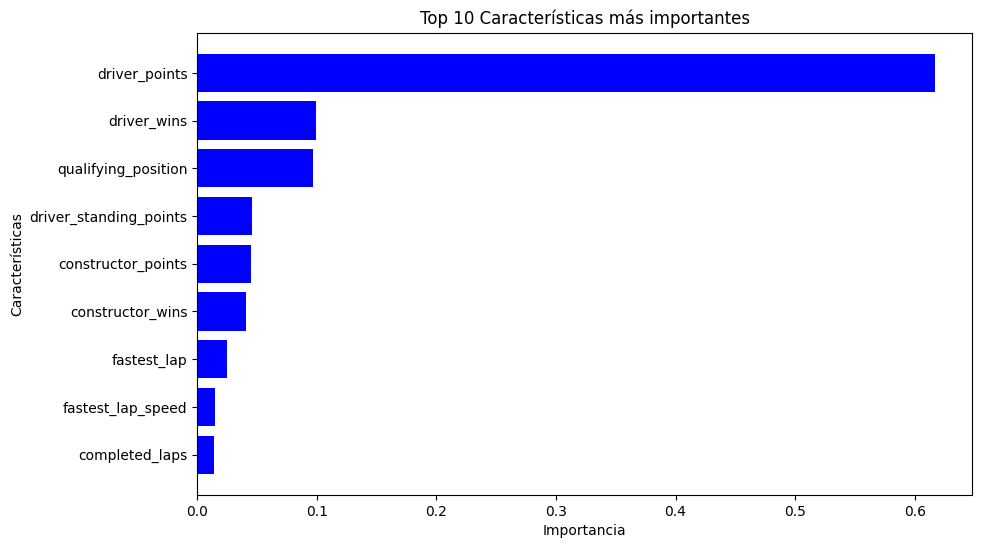

In [42]:
features_seleccionadas = calcular_feature_importance(df=df_labeled[df_labeled['dataset'] == 'train'], n=10)

### Model Training

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

def entrenar_logit_binario(df, target='final_position'):
    # Eliminar las columnas no numéricas que no aportan valor al modelo
    #df = df.drop(columns=['driverId', 'year', 'dataset'], errors='ignore')
    
    # Separar las características (X) y la variable objetivo (y) para cada dataset
    X_train = df[df['dataset'] == 'train'].drop(columns=[target,'dataset'])
    y_train = df[df['dataset'] == 'train'][target]
    
    X_test = df[df['dataset'] == 'test'].drop(columns=[target,'dataset'])
    y_test = df[df['dataset'] == 'test'][target]
    
    X_val = df[df['dataset'] == 'validation'].drop(columns=[target,'dataset'])
    y_val = df[df['dataset'] == 'validation'][target]
    
    # Verificar que todas las columnas sean de tipo numérico
    X_train = X_train.select_dtypes(include=['int64', 'float64', 'bool'])
    X_test = X_test.select_dtypes(include=['int64', 'float64', 'bool'])
    X_val = X_val.select_dtypes(include=['int64', 'float64', 'bool'])

    # Crear el modelo de regresión logística
    logit_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    
    # Ajustar el modelo
    logit_model.fit(X_train, y_train)
    
    # Predecir en los conjuntos de test y validation
    y_pred_test = logit_model.predict(X_test)
    y_pred_val = logit_model.predict(X_val)
    
    # Calcular las métricas para test
    print("Métricas para el conjunto de Test:")
    print(classification_report(y_test, y_pred_test))
    
    # Calcular las métricas para validation
    print("Métricas para el conjunto de Validación:")
    print(classification_report(y_val, y_pred_val))
    
    # Calcular precisión general (accuracy) para test y validation
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    
    # Calcular recall general para test y validation
    recall_test = recall_score(y_test, y_pred_test)
    recall_val = recall_score(y_val, y_pred_val)
    
    # Calcular precisión general para test y validation
    precision_test = precision_score(y_test, y_pred_test)
    precision_val = precision_score(y_val, y_pred_val)
    
    print(f"Precisión en Test: {accuracy_test:.4f}")
    print(f"Recall en Test: {recall_test:.4f}")
    print(f"Precisión general en Test: {precision_test:.4f}")
    
    print(f"Precisión en Validación: {accuracy_val:.4f}")
    print(f"Recall en Validación: {recall_val:.4f}")
    print(f"Precisión general en Validación: {precision_val:.4f}")
    
    # Retornar el modelo ajustado
    return logit_model


In [62]:
%%time
modelo_logit = entrenar_logit_binario(df_labeled[features_seleccionadas + ['final_position','dataset']])

Métricas para el conjunto de Test:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1465
           1       0.53      0.99      0.69        83

    accuracy                           0.95      1548
   macro avg       0.77      0.97      0.83      1548
weighted avg       0.97      0.95      0.96      1548

Métricas para el conjunto de Validación:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1465
           1       0.50      0.89      0.64        82

    accuracy                           0.95      1547
   macro avg       0.75      0.92      0.81      1547
weighted avg       0.97      0.95      0.95      1547

Precisión en Test: 0.9528
Recall en Test: 0.9880
Precisión general en Test: 0.5325
Precisión en Validación: 0.9476
Recall en Validación: 0.8902
Precisión general en Validación: 0.5034
CPU times: total: 172 ms
Wall time: 64.5 ms


In [72]:
# Obtener los nombres de las columnas que el modelo espera
print(modelo_logit.feature_names_in_)

['driver_points' 'driver_wins' 'qualifying_position'
 'driver_standing_points' 'constructor_points' 'constructor_wins'
 'fastest_lap' 'fastest_lap_speed' 'completed_laps']


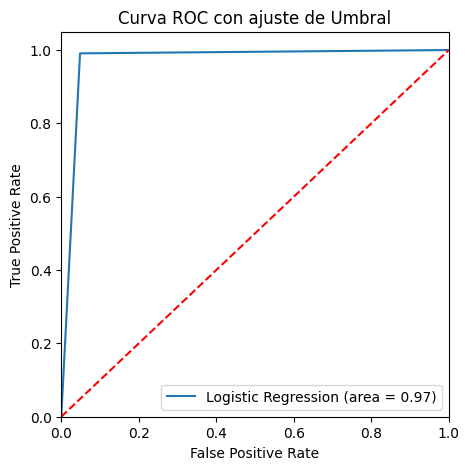

In [76]:
thres = 0.5
X_train = df_labeled[df_labeled[features_seleccionadas + ['final_position','dataset']]['dataset'] == 'train'].drop(columns=['final_position','dataset','driverId','year'])
X_train =X_train[modelo_logit.feature_names_in_]
y_train = df_labeled[df_labeled[features_seleccionadas + ['final_position','dataset']]['dataset'] == 'train']['final_position']


logit_roc_auc = roc_auc_score(y_train, modelo_logit.predict(X_train))  ## Calculo el area bajo la curva

y_pred= np.where(modelo_logit.predict_proba(X_train)[:,1] > thres, 1, 0)

fpr, tpr, thresholds = roc_curve(y_train, y_pred) ## Calculo la fpr(false positive rate),
## la tpr(true positive rate) y thresholds (los umbrales)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC con ajuste de Umbral')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [77]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Obtener las probabilidades predichas para la clase 1 (ganador)
y_probs_train = modelo_logit.predict_proba(X_train)[:, 1]

# Calcular precisión, recall y los umbrales correspondientes
precision, recall, thresholds = precision_recall_curve(y_train, y_probs_train)

# Calcular la F1-score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontrar el umbral que maximiza el F1-score (balance entre precisión y recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"El mejor umbral basado en el F1-score es: {best_threshold:.2f}")


El mejor umbral basado en el F1-score es: 0.87


In [78]:
def ajustar_umbral_modelo(model, X_test, y_test, threshold=0.87):
    # Obtener las probabilidades predichas para la clase 1 (ganador)
    y_probs_test = model.predict_proba(X_test)[:, 1]
    
    # Ajustar las predicciones según el nuevo umbral
    y_pred_test_threshold = (y_probs_test >= threshold).astype(int)
    
    # Calcular las métricas para test con el nuevo umbral
    print(f"Métricas para el conjunto de Test con umbral ajustado a {threshold}:")
    print(classification_report(y_test, y_pred_test_threshold))
    
    # Calcular precisión, recall y F1
    accuracy = accuracy_score(y_test, y_pred_test_threshold)
    recall = recall_score(y_test, y_pred_test_threshold)
    precision = precision_score(y_test, y_pred_test_threshold)
    
    print(f"Precisión con umbral {threshold}: {accuracy:.4f}")
    print(f"Recall con umbral {threshold}: {recall:.4f}")
    print(f"Precisión general con umbral {threshold}: {precision:.4f}")



In [89]:
X_test = df_labeled[df_labeled[features_seleccionadas + ['final_position','dataset']]['dataset'] == 'test']
X_test =X_test[modelo_logit.feature_names_in_]

y_test = df_labeled[df_labeled['dataset'] == 'test']['final_position']

# Ajustar el umbral a 0.6, por ejemplo
ajustar_umbral_modelo(modelo_logit, X_test, y_test, threshold=0.87)

Métricas para el conjunto de Test con umbral ajustado a 0.87:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1465
           1       0.85      0.82      0.83        83

    accuracy                           0.98      1548
   macro avg       0.92      0.91      0.91      1548
weighted avg       0.98      0.98      0.98      1548

Precisión con umbral 0.87: 0.9826
Recall con umbral 0.87: 0.8193
Precisión general con umbral 0.87: 0.8500


In [91]:
X_test = df_labeled[df_labeled[features_seleccionadas + ['final_position','dataset']]['dataset'] == 'validation']
X_test =X_test[modelo_logit.feature_names_in_]

y_test = df_labeled[df_labeled['dataset'] == 'validation']['final_position']

# Ajustar el umbral a 0.6, por ejemplo
ajustar_umbral_modelo(modelo_logit, X_test, y_test, threshold=0.87)

Métricas para el conjunto de Test con umbral ajustado a 0.87:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1465
           1       0.83      0.66      0.73        82

    accuracy                           0.97      1547
   macro avg       0.91      0.83      0.86      1547
weighted avg       0.97      0.97      0.97      1547

Precisión con umbral 0.87: 0.9748
Recall con umbral 0.87: 0.6585
Precisión general con umbral 0.87: 0.8308


## Xgboost

In [59]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

def entrenar_xgboost_binario(df, target='final_position'):
    # Eliminar las columnas no numéricas que no aportan valor al modelo
    #df = df.drop(columns=['driverId', 'year', 'dataset'], errors='ignore')
    
    # Separar las características (X) y la variable objetivo (y) para cada dataset
    X_train = df[df['dataset'] == 'train'].drop(columns=[target,'dataset'])
    y_train = df[df['dataset'] == 'train'][target]
    
    X_test = df[df['dataset'] == 'test'].drop(columns=[target,'dataset'])
    y_test = df[df['dataset'] == 'test'][target]
    
    X_val = df[df['dataset'] == 'validation'].drop(columns=[target,'dataset'])
    y_val = df[df['dataset'] == 'validation'][target]
    
    # Verificar que todas las columnas sean de tipo numérico
    X_train = X_train.select_dtypes(include=['int64', 'float64', 'bool'])
    X_test = X_test.select_dtypes(include=['int64', 'float64', 'bool'])
    X_val = X_val.select_dtypes(include=['int64', 'float64', 'bool'])

    # Calcular pesos de clase para balancear las clases
    class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    pos_weight = class_weight[1] / class_weight[0]

    # Crear el modelo base XGBoost
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        #scale_pos_weight=15,  # Ajustar el peso de la clase positiva
        eval_metric='logloss'         # Métrica de evaluación para clasificación binaria
    )

    # Definir el espacio de hiperparámetros para RandomizedSearchCV
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0.01, 0.1, 1],
        'reg_lambda': [0.01, 0.1, 1],
        'min_child_weight': [1, 3, 5]
    }

    # Convertir los valores de 'n_estimators', 'max_depth' y 'min_child_weight' a enteros
    param_distributions['n_estimators'] = [int(value) for value in param_distributions['n_estimators']]
    param_distributions['max_depth'] = [int(value) for value in param_distributions['max_depth']]
    param_distributions['min_child_weight'] = [int(value) for value in param_distributions['min_child_weight']]

    # Configurar RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=30,                 # Número de combinaciones a probar
        scoring='precision',        # Usamos precisión para evaluar
        cv=3,                      # Validación cruzada con 3 folds
        verbose=1,                 # Nivel de verbosidad
        random_state=42,           # Para reproducibilidad
        n_jobs=-1                  # Usar todos los procesadores disponibles
    )

    # Ajustar el modelo con RandomizedSearchCV
    randomized_search.fit(X_train, y_train)
    
    # Obtener el mejor modelo
    best_model = randomized_search.best_estimator_

    # Predecir en los conjuntos de test y validation
    y_pred_test = best_model.predict(X_test)
    y_pred_val = best_model.predict(X_val)
    
    # Calcular las métricas para test
    print("Métricas para el conjunto de Test:")
    print(classification_report(y_test, y_pred_test))
    
    # Calcular las métricas para validation
    print("Métricas para el conjunto de Validación:")
    print(classification_report(y_val, y_pred_val))
    
    # Calcular precisión general (accuracy) para test y validation
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    
    # Calcular recall general para test y validation
    recall_test = recall_score(y_test, y_pred_test)
    recall_val = recall_score(y_val, y_pred_val)
    
    # Calcular precisión general para test y validation
    precision_test = precision_score(y_test, y_pred_test)
    precision_val = precision_score(y_val, y_pred_val)
    
    print(f"Precisión en Test: {accuracy_test:.4f}")
    print(f"Recall en Test: {recall_test:.4f}")
    print(f"Precisión general en Test: {precision_test:.4f}")
    
    print(f"Precisión en Validación: {accuracy_val:.4f}")
    print(f"Recall en Validación: {recall_val:.4f}")
    print(f"Precisión general en Validación: {precision_val:.4f}")
    
    # Retornar el mejor modelo ajustado
    return best_model


In [60]:
%%time
modelo_xgboost_regularizado = entrenar_xgboost_binario(df_labeled[features_seleccionadas + ['final_position','dataset']])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Métricas para el conjunto de Test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1465
           1       0.99      1.00      0.99        83

    accuracy                           1.00      1548
   macro avg       0.99      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548

Métricas para el conjunto de Validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1465
           1       0.99      0.94      0.96        82

    accuracy                           1.00      1547
   macro avg       0.99      0.97      0.98      1547
weighted avg       1.00      1.00      1.00      1547

Precisión en Test: 0.9994
Recall en Test: 1.0000
Precisión general en Test: 0.9881
Precisión en Validación: 0.9961
Recall en Validación: 0.9390
Precisión general en Validación: 0.9872
CPU times: total: 797 ms


## Randon forest

In [13]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

def entrenar_random_forest_binario(df, target='final_position'):
    # Eliminar las columnas no numéricas que no aportan valor al modelo
    df = df.drop(columns=['driverId', 'year'], errors='ignore')
    
    # Separar las características (X) y la variable objetivo (y) para cada dataset
    X_train = df[df['dataset'] == 'train'].drop(columns=[target, 'dataset'])
    y_train = df[df['dataset'] == 'train'][target]
    
    X_test = df[df['dataset'] == 'test'].drop(columns=[target, 'dataset'])
    y_test = df[df['dataset'] == 'test'][target]
    
    X_val = df[df['dataset'] == 'validation'].drop(columns=[target, 'dataset'])
    y_val = df[df['dataset'] == 'validation'][target]
    
    # Verificar que todas las columnas sean de tipo numérico
    X_train = X_train.select_dtypes(include=['int64', 'float64', 'bool'])
    X_test = X_test.select_dtypes(include=['int64', 'float64', 'bool'])
    X_val = X_val.select_dtypes(include=['int64', 'float64', 'bool'])

    # Calcular pesos de clase para balancear las clases
    class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weight)}
    
    # Crear el modelo base Random Forest
    rf_model = RandomForestClassifier(
        random_state=42,
        class_weight=class_weight_dict  # Ajustar los pesos de las clases para balancear el modelo
    )

    # Definir el espacio de hiperparámetros para RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(100, 500),     # Número de árboles entre 100 y 500
        'max_depth': randint(3, 20),           # Profundidad máxima de los árboles entre 3 y 20
        'min_samples_split': randint(2, 20),   # Número mínimo de muestras requeridas para dividir un nodo
        'min_samples_leaf': randint(1, 20),    # Número mínimo de muestras por hoja
        'max_features': uniform(0.5, 1.0),     # Fracción de características usadas por árbol
        'bootstrap': [True, False]             # Usar o no Bootstrap
    }

    # Configurar RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_distributions,
        n_iter=10,                 # Número de combinaciones a probar
        scoring='accuracy',        # Usamos precisión para evaluar
        cv=3,                      # Validación cruzada con 3 folds
        verbose=1,                 # Nivel de verbosidad
        random_state=42,           # Para reproducibilidad
        n_jobs=-1                  # Usar todos los procesadores disponibles
    )

    # Ajustar el modelo con RandomizedSearchCV
    randomized_search.fit(X_train, y_train)
    
    # Obtener el mejor modelo
    best_model = randomized_search.best_estimator_

    # Predecir en los conjuntos de test y validation
    y_pred_test = best_model.predict(X_test)
    y_pred_val = best_model.predict(X_val)
    
    # Calcular las métricas para test
    print("Métricas para el conjunto de Test:")
    print(classification_report(y_test, y_pred_test))
    
    # Calcular las métricas para validation
    print("Métricas para el conjunto de Validación:")
    print(classification_report(y_val, y_pred_val))
    
    # Calcular precisión general (accuracy) para test y validation
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    
    # Calcular recall general para test y validation
    recall_test = recall_score(y_test, y_pred_test)
    recall_val = recall_score(y_val, y_pred_val)
    
    # Calcular precisión general para test y validation
    precision_test = precision_score(y_test, y_pred_test)
    precision_val = precision_score(y_val, y_pred_val)
    
    print(f"Precisión en Test: {accuracy_test:.4f}")
    print(f"Recall en Test: {recall_test:.4f}")
    print(f"Precisión general en Test: {precision_test:.4f}")
    
    print(f"Precisión en Validación: {accuracy_val:.4f}")
    print(f"Recall en Validación: {recall_val:.4f}")
    print(f"Precisión general en Validación: {precision_val:.4f}")
    
    # Retornar el mejor modelo ajustado
    return best_model


In [14]:
entrenar_random_forest_binario(df_labeled[features_seleccionadas + ['final_position','dataset']], target='final_position')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    

Métricas para el conjunto de Test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1482
           1       0.96      1.00      0.98        66

    accuracy                           1.00      1548
   macro avg       0.98      1.00      0.99      1548
weighted avg       1.00      1.00      1.00      1548

Métricas para el conjunto de Validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1472
           1       0.93      0.99      0.95        75

    accuracy                           1.00      1547
   macro avg       0.96      0.99      0.98      1547
weighted avg       1.00      1.00      1.00      1547

Precisión en Test: 0.9981
Recall en Test: 1.0000
Precisión general en Test: 0.9565
Precisión en Validación: 0.9955
Recall en Validación: 0.9867
Precisión general en Validación: 0.9250


RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.5279863481228669,
                                     1: 9.432926829268293},
                       max_depth=8, max_features=0.5007787658410143,
                       min_samples_split=13, n_estimators=413, random_state=42)

In [49]:
# Contar filas duplicadas en todo el dataframe
duplicados_totales = df_labeled.duplicated().sum()
print(f'Total de filas duplicadas: {duplicados_totales}')


Total de filas duplicadas: 0


In [16]:
df_labeled.shape

(7736, 13)